In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 

## Gaussian Processes
this is based on a nice tutorial from https://peterroelants.github.io/posts/gaussian-process-tutorial/

In [2]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb): 
    #   """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

In [4]:
import scipy

In [12]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise, n1):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + σ_noise * np.eye(n1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    print('sig12 shape',Σ12.shape)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [13]:
import pickle
six = pickle.load(open('six_stations.pkl', 'rb'))
for i in range(6):
    six[i] = np.array(six[i])[:,1]
sixave = np.zeros(360)
for i in range(6):
    sixave += six[i][:360]
sixave = sixave/6.0

Text(0, 0.5, '$y = f(x)$')

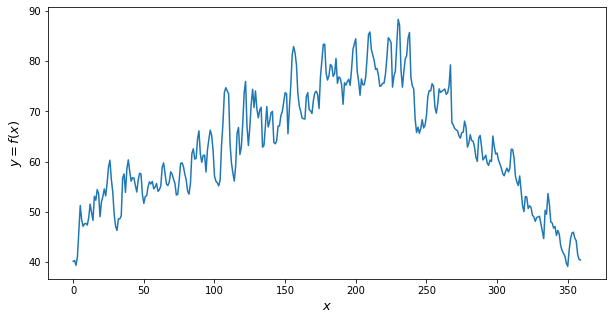

In [14]:
plt.figure( figsize=(10,5))
    
plt.plot(sixave)

plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)


The following is the perodic kernel with a slightly extended period

In [290]:
def periodic(xa, xb):
    w = np.sin(np.pi*np.abs(xa-xb)/1.15)
    z = np.exp(-2.0*w*w)
    return z

bigperiodic is the linear combination of periodic and exponentiated quadratic

In [328]:
def bigperiodic(xa, xb):
    lamda = 0.5
    xas = xa.shape[0]
    xbs = xb.shape[0]
    w  = np.zeros((xas, xbs))
    for i in range(xas):
        w[i, :] = periodic(xa[i], xb.reshape(xbs))
    return w + 1.0*exponentiated_quadratic(xa, xb)

to see what how the kernel above looks with the noise factor added
$$
k(x_1, x_2) ~=~ k_{eq}(x_1, x_2) ~+~ k_p(x_1, x_2) ~+~  \sigma^2 I_n
$$
where 
$$
\sigma^2 = 0.01
$$

In [372]:
def k(xa, xb):
    lamda = 0.5
    xas = xa.shape[0]
    xbs = xb.shape[0]
    w  = np.zeros((xas, xbs))
    w2 = np.zeros((xas, xbs))
    for i in range(xas):
        w2[i, :] = periodic(xa[i], xb.reshape(xbs))
        w[i, :] = np.zeros(xbs)
        w[i,i] = 0.01
    return w+w2+ 1.0*exponentiated_quadratic(xa, xb)

In [374]:
X = np.linspace(0, 2, 300).reshape(-1,1)
Σ = k(X,X)
ys = np.random.multivariate_normal(mean=np.zeros(300)+10, cov=Σ, size=1)

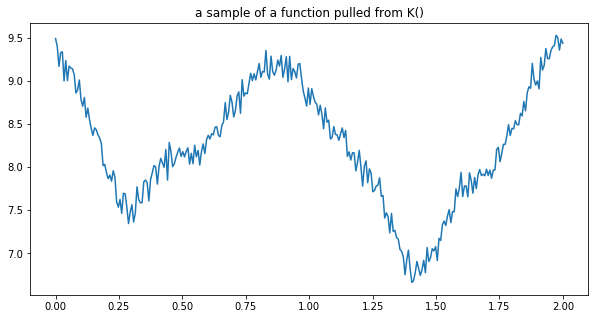

In [375]:
fig, ax1 = plt.subplots(nrows=1, ncols=1,  figsize=(10,5))
ax1.plot(X, ys.T, '-')
plt.title(('a sample of a function pulled from K()'))
plt.show() 

The following function builds the gaussian process for the weather data.  It first scales the data by a factor of 10.   
then it akes the interval of days from 0 to n1 and picks days that are spaced "days" apart.   k is the noise factor.   

It then builds the Gaussian and extracts 3 functions and plots the result.

Finally, it computes some basic statistics.

In [292]:
def make_gaussian(data, n1=230, k=0.05, days=15):
    ny = 3
    n2 = 360
    
    y = data[0:n2]/10.0
    X2 = np.linspace(0, 1, n2).reshape(-1,1)
    last = days*(int(n1/days)-1)
    i1 = [i*days for i in range(int(n1/days))]
    short =  len(i1)
    X1 = np.zeros(short)
    y_samp = np.zeros(short)
    print(len(y_samp))
    print(len(y))
    for i in range(short):
        X1[i]= X2[i1[i]]
        y_samp[i] = y[i1[i]]
    X1 = X1.reshape(short,1)
    y_samp = y_samp.reshape(short,1)
    
    # Compute posterior mean and covariance
    μ2, Σ2 = GP_noise(X1, y_samp,X2, bigperiodic, k, short)

    # Compute the standard deviation at the test points to be plotted
    σ2 = np.sqrt(np.diag(Σ2)).reshape(-1,1)

    # Draw some samples of the posterior, cov=Σ2, size=ny)
    
    y2 = np.random.multivariate_normal(mean=μ2.reshape(n2), cov=Σ2, size=3)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,  figsize=(10,10))
    # Plot the distribution of the function (mean, covariance)
    ax1.plot(X2, y, 'b--', label='$raw data$')
    ax1.plot(X2, y2.T, '-')

    xx = X1
    yy = y_samp
    ax1.scatter(xx,yy, s=30, color='red')

    u = μ2-2*σ2
    v = μ2+2*σ2
    u = u.reshape(n2)
    v = v.reshape(n2)
    ax1.fill_between(X2.flat, u,v, color='red', 
                     alpha=0.15, label='$2\sigma_{2|1}$')
    ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
    ax1.set_xlabel('$x$', fontsize=13)
    ax1.set_ylabel('$y$', fontsize=13)
    ax1.set_title('Distribution of posterior and prior data')
    ax1.legend()
    # Plot some samples from this function
    ax2.plot(X2, y2.T, '-')
    ax2.set_xlabel('$x$', fontsize=13)
    ax2.set_ylabel('$y$', fontsize=13)
    ax2.set_title('3 different function realizations from posterior')
    plt.tight_layout()
    plt.show()

    err = 0.0
    errsq  = 0.0
    cnt = 0
    badday  =0.0
    u = 10*μ2.reshape(360)
    for i in range(360):
        err += np.abs(data[i]-u[i])
        errsq += np.abs(data[i]-u[i])*np.abs(data[i]-u[i])
        if (data[i]-u[i]) > 10 or (data[i]-u[i]) < -10:
            badday += np.abs(data[i]-u[i])
            cnt +=1
    print("l1 error=", err/360)
    err = np.sqrt(errsq)/360.0
    print("l2 error=", err)
    print('days over 10 degrees wrong =', cnt)
    if cnt > 0:
        print("average bad day = ", badday/cnt)    

46
360
sig12 shape (46, 360)


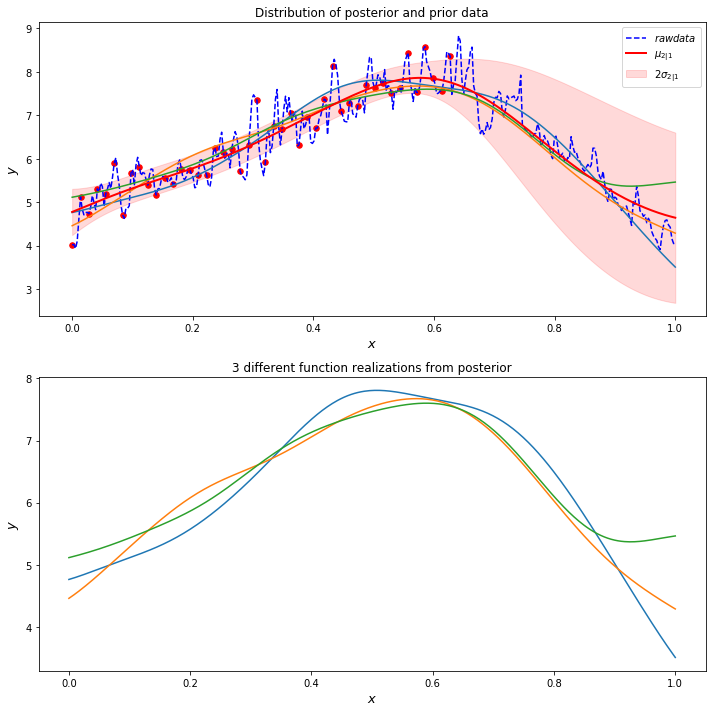

l1 error= 3.171950138108652
l2 error= 0.21418700279368738
days over 10 degrees wrong = 8
average bad day =  10.711599248840447


In [293]:
make_gaussian(sixave, n1=230, k = 0.3, days=5)

In the following six[0] is station that has some anomolous behavior for a week in the late summer.

46
360
sig12 shape (46, 360)


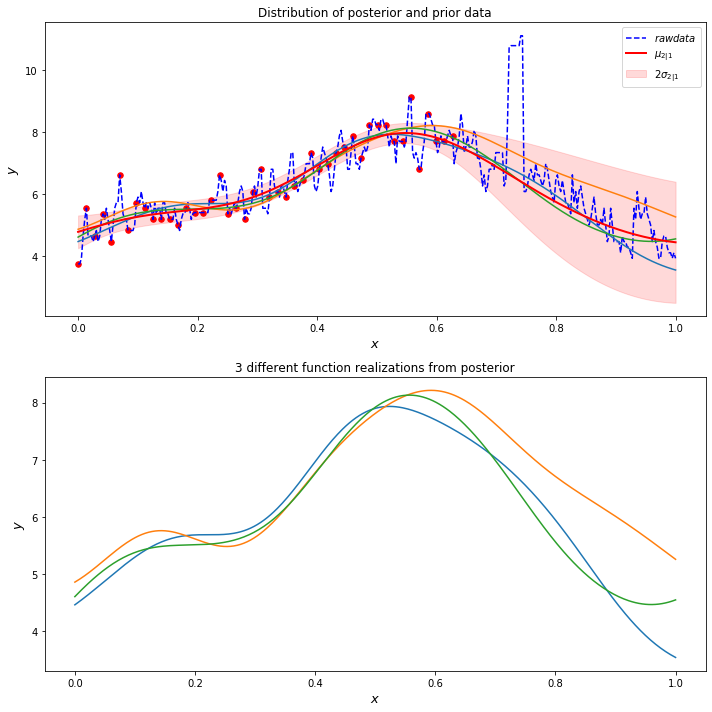

l1 error= 4.992902598008102
l2 error= 0.44607248046127285
days over 10 degrees wrong = 25
average bad day =  23.261523316885885


In [294]:
make_gaussian(six[0], n1=230, k = 0.3, days=5)

15
360
sig12 shape (15, 360)


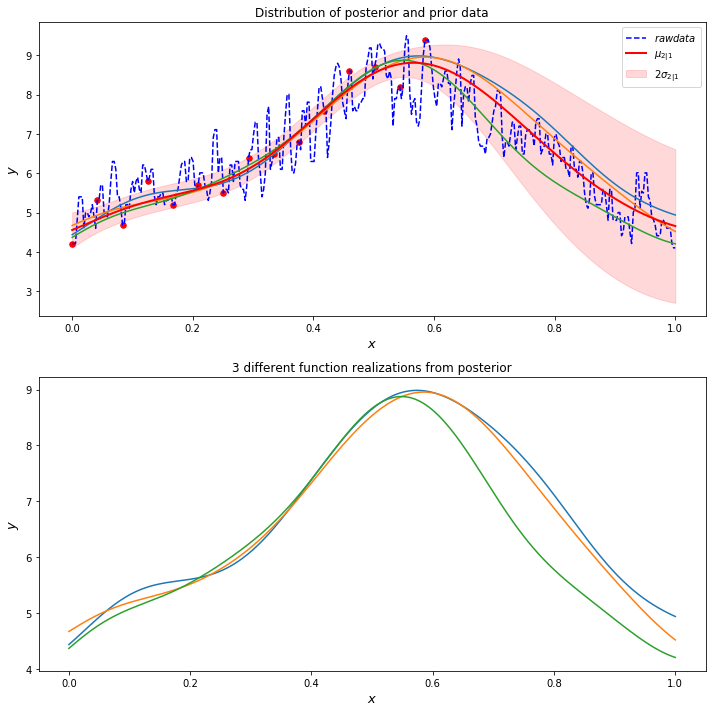

l1 error= 4.776502964435203
l2 error= 0.31507807280358213
days over 10 degrees wrong = 35
average bad day =  12.500991863191723


In [295]:
make_gaussian(six[1], n1=230, k=0.09, days=15)

15
360
sig12 shape (15, 360)


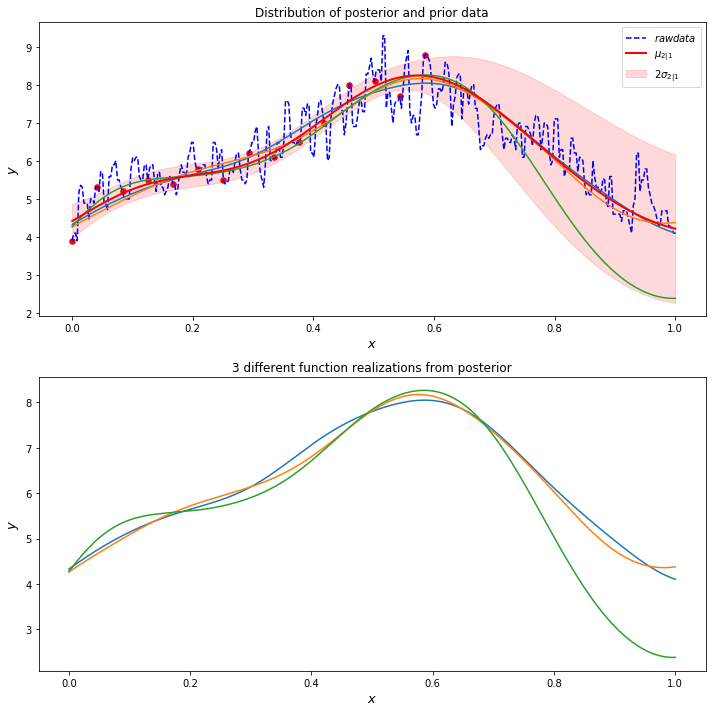

l1 error= 4.394681429001419
l2 error= 0.2897980461434155
days over 10 degrees wrong = 25
average bad day =  12.295135286729808


In [296]:
make_gaussian(six[2], n1=230, k = 0.09)

50
360
sig12 shape (50, 360)


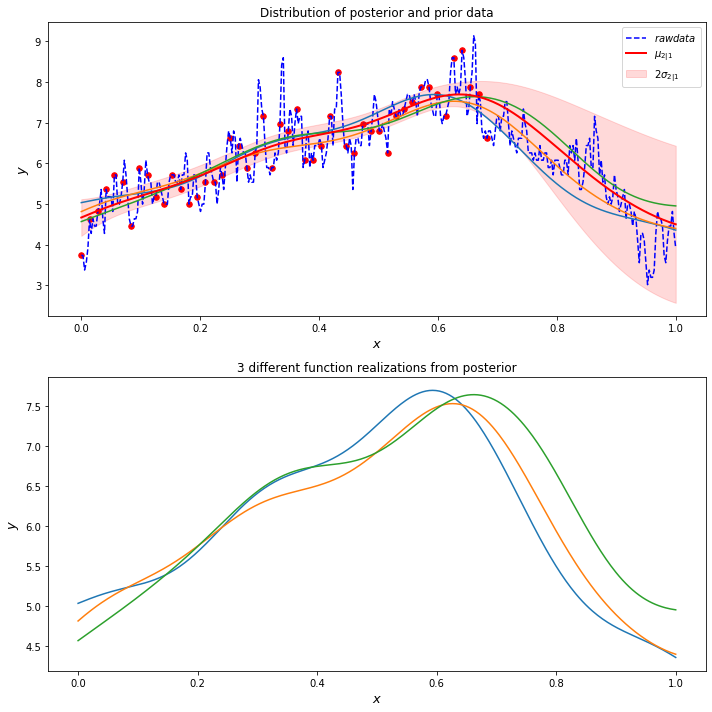

l1 error= 4.573355191346889
l2 error= 0.3075700256305861
days over 10 degrees wrong = 26
average bad day =  13.891809660072314


In [278]:
make_gaussian(six[3], n1=250, k=0.2, days=5)

15
360
sig12 shape (15, 360)


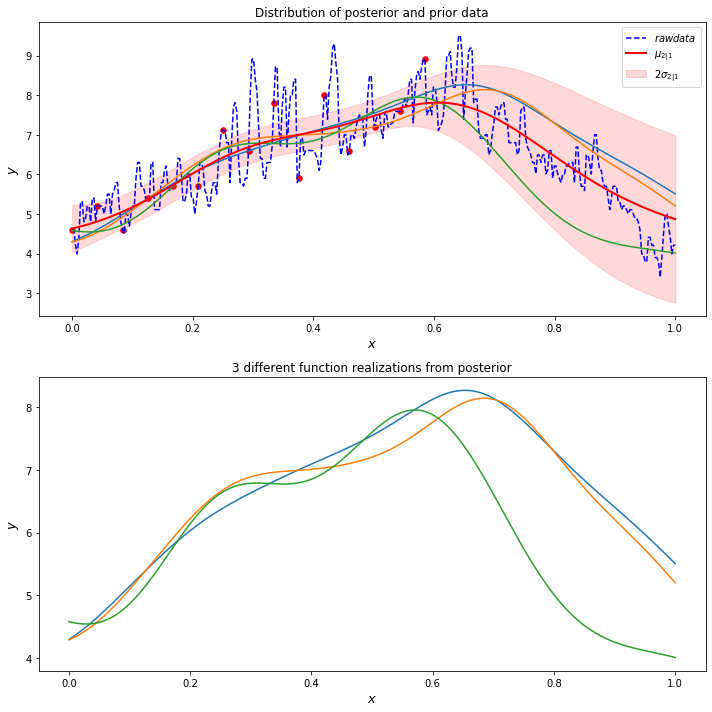

l1 error= 5.323291322551246
l2 error= 0.35967790787648696
days over 10 degrees wrong = 55
average bad day =  13.287571286001112


In [281]:
make_gaussian(six[4], n1=230, k =0.2, days = 15)

[0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270]
19
360
sig12 shape (19, 360)
y2 shape (3, 360)


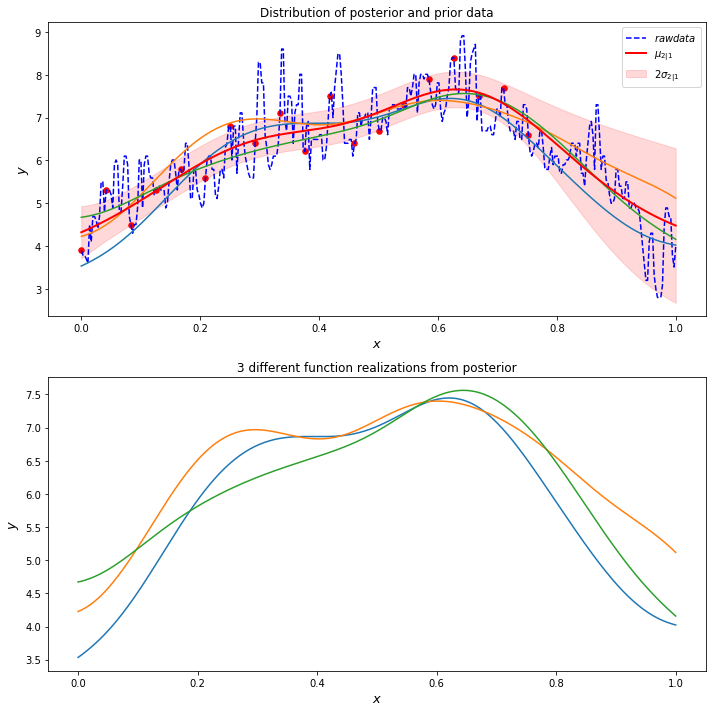

l1 error= 5.027300462702428
l2 error= 0.34390372219619214
days over 10 degrees wrong = 38
average bad day =  14.209497112011078


In [217]:
make_gaussian(six[5], n1=285, k = 0.2)